<a href="https://colab.research.google.com/github/marcellobeer/IMT_CD_Proj1/blob/main/Projeto1_DS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/Rogerio-mack/IMT_CD_2024/blob/main/maua_logo.png?raw=true" width=300, align="right">



# **Exploratory Data Analysis (EDA)**
## Análise de Desempenho das Equipes Finalistas da NBA na temporada 2023-24: **Dallas Mavericks vs. Boston Celtics**

In [1]:
#@title **Identificação do Grupo**

#@markdown Nomes completos em ordem alfabética (*\<nome\>, \<RA\>*)
Aluno1 = 'Daniel Scabar, 18017754' #@param {type:"string"}
Aluno2 = 'Marcello Beer, 17008654' #@param {type:"string"}





# **Resumo (*Abstract*)**

Este estudo analisa o desempenho do Boston Celtics e do Dallas Mavericks durante a temporada 2023-24 da NBA, focando em métricas chave dos times, como padrões de pontuação, desempenho defensivo e consistência ao longo da temporada. Utilizando dados da API de Estatísticas da NBA, examinamos os registros de jogos de ambos os times para obter insights sobre seus pontos fortes e fracos. As descobertas oferecem insights valiosos para fãs, analistas e profissionais da indústria esportiva, melhorando a compreensão das dinâmicas dos times e abordagens estratégicas no basquete profissional.

# **Introdução**



# **Descrição e origem dos dados**

API Client Package para acessar API do site oficial da NBA: https://www.nba.com/stats

<center>Figura 1 – Estrutura API NBA

<img src="https://raw.githubusercontent.com/swar/nba_api/b25107891ecb86cb385c9dc6c2b79e7c08d31c06/docs/images/structure.svg"  width=1400, align="center">

<small><center> **Fonte: https://github.com/swar/nba_api/tree/master**







# **Aquisição e Preparação dos dados**

Faça aqui a aquisição dos dados, justificando e incluindo aqui eventuais reduções as efetuadas.

Não deixe de descrever e justificar reduções (seleções) feitas nos dados originais para os seus propósitos (por exemplo, selecionou somente dados do último ano, somente dados de países da América Latina ou selecionou somente algumas tabelas dentre várias tabelas disponíveis).








In [1]:
!pip install nba_api

In [2]:
from nba_api.stats.static import teams
from nba_api.stats.endpoints import teamgamelog
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
# Função para obter o ID do time
def get_team_id(team_name):
    nba_teams = teams.get_teams()
    for team in nba_teams:
        if team['full_name'] == team_name:
            return team['id']
    return None

# Função para obter os logs de jogos do time para a temporada atual
def get_team_gamelog(team_id):
    try:
        gamelog = teamgamelog.TeamGameLog(team_id=team_id, season='2023-24').get_data_frames()[0]
        return gamelog
    except Exception as e:
        print(f"Could not retrieve game logs for team ID {team_id}: {e}")
        return pd.DataFrame()


# Função para limpar os dados e lidar com valores nulos
def clean_team_data(df):
    df.fillna(0, inplace=True)
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
    return df

# Obter logs de jogos dos Celtics e Mavericks
celtics_id = get_team_id('Boston Celtics')
mavericks_id = get_team_id('Dallas Mavericks')

celtics_gamelog = get_team_gamelog(celtics_id)
mavericks_gamelog = get_team_gamelog(mavericks_id)

# Adicionar uma coluna 'Team' para identificação
celtics_gamelog['Team'] = 'Boston Celtics'
mavericks_gamelog['Team'] = 'Dallas Mavericks'

# Combinar os dados dos dois times para consistência na análise
team_gamelogs = pd.concat([celtics_gamelog, mavericks_gamelog], ignore_index=True)

# Limpar os dados combinados
cleaned_team_gamelogs = clean_team_data(team_gamelogs)

print(cleaned_team_gamelogs.head())

      Team_ID     Game_ID     GAME_DATE      MATCHUP WL   W   L  W_PCT  MIN  \
0  1610612738  0022301186  APR 14, 2024  BOS vs. WAS  W  64  18  0.780  240   
1  1610612738  0022301173  APR 12, 2024  BOS vs. CHA  W  63  18  0.778  240   
2  1610612738  0022301167  APR 11, 2024  BOS vs. NYK  L  62  18  0.775  240   
3  1610612738  0022301148  APR 09, 2024    BOS @ MIL  L  62  17  0.785  240   
4  1610612738  0022301134  APR 07, 2024  BOS vs. POR  W  62  16  0.795  240   

   FGM  ...  OREB  DREB  REB  AST  STL  BLK  TOV  PF  PTS            Team  
0   51  ...    10    38   48   29   10   15   14  13  132  Boston Celtics  
1   54  ...    16    37   53   34   12    1    6  20  131  Boston Celtics  
2   40  ...    10    26   36   25    7   12   12  16  109  Boston Celtics  
3   37  ...    12    26   38   27   11    4   12   8   91  Boston Celtics  
4   49  ...     5    35   40   34   11    8   12  12  124  Boston Celtics  

[5 rows x 28 columns]


# **Análises**


## **Q1.** Qual é a taxa de vitória de cada time jogando dentro e fora de casa?
* Essa análise investiga a taxa de vitórias dentro e fora de casa de cada time, na temporada de 2023-24, permitindo entender como seu desempenho se comporta com relação ao local da partida.

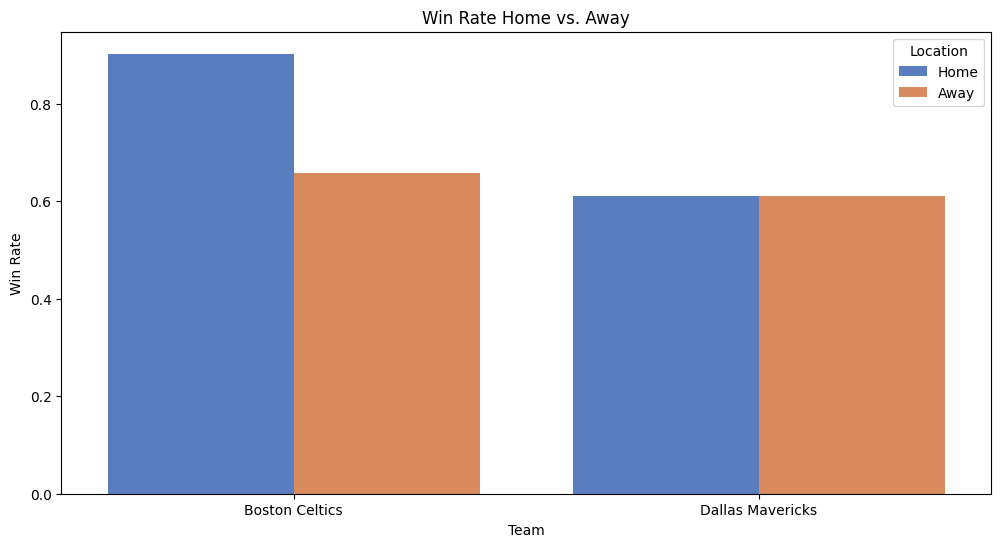

In [4]:
# Função para taxa de vitória em casa e fora de casa no mesmo gráfico
def win_rate_home_away(df):
    df['Win'] = df['WL'] == 'W'
    home_games = df[df['MATCHUP'].str.contains('vs.')]
    away_games = df[df['MATCHUP'].str.contains('@')]

    home_win_rate = home_games.groupby('Team')['Win'].mean().reset_index()
    home_win_rate['Location'] = 'Home'
    away_win_rate = away_games.groupby('Team')['Win'].mean().reset_index()
    away_win_rate['Location'] = 'Away'

    win_rate = pd.concat([home_win_rate, away_win_rate], ignore_index=True)

    plt.figure(figsize=(12, 6))
    sns.barplot(x='Team', y='Win', hue='Location', data=win_rate, palette='muted')
    plt.title('Win Rate Home vs. Away')
    plt.ylabel('Win Rate')
    plt.xlabel('Team')
    plt.show()

win_rate_home_away(cleaned_team_gamelogs)

### **Conclusão**

Boston claramente possui um melhor desempenho jogando em casa, enquanto o desempenho de Dallas não parece ser afetado pelo local da partida.

## **Q2.** Nessa temporada, qual foi a distribuição de pontos por partida de cada time, e a frequência em que cada um atingiu tal placar? Qual a variância de cada time no total de pontos de uma partida ao longo da temporada?
* Essa análise permite entender como cada time pontuou ao longo da temporada, os placares mais frequentes e a variância relativa do total de pontos numa partida de cada um dos times.

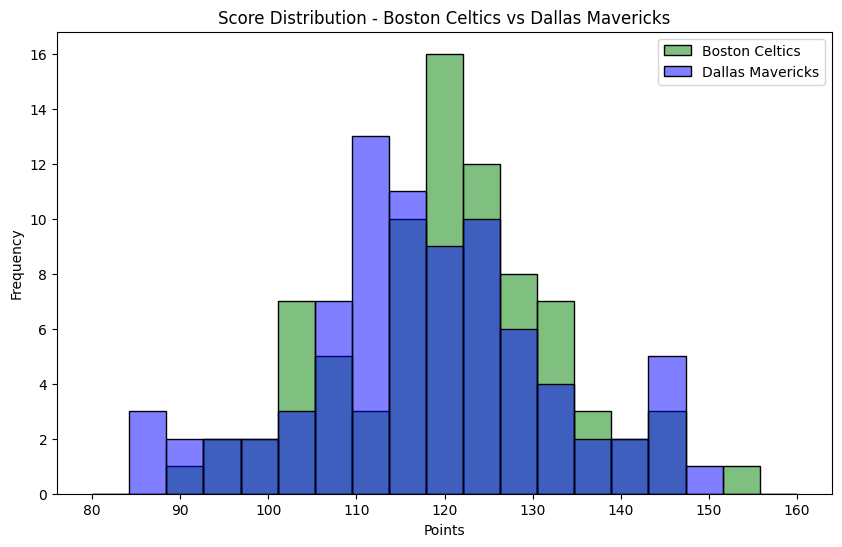

In [5]:
# Função para plotar histogramas das pontuações dos times lado a lado sem sobreposição
def plot_score_histograms(df):
    plt.figure(figsize=(10, 6))

    # Define bins for the histogram
    bins = np.linspace(80, 160, 20)

    # Histogram for Boston Celtics
    sns.histplot(df[df['Team'] == 'Boston Celtics']['PTS'], bins=bins, kde=False, color='green', label='Boston Celtics', alpha=0.5)

    # Histogram for Dallas Mavericks
    sns.histplot(df[df['Team'] == 'Dallas Mavericks']['PTS'], bins=bins, kde=False, color='blue', label='Dallas Mavericks', alpha=0.5)

    plt.title('Score Distribution - Boston Celtics vs Dallas Mavericks')
    plt.xlabel('Points')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

plot_score_histograms(cleaned_team_gamelogs)

In [6]:
    # Performance consistency
    points_variance = cleaned_team_gamelogs.groupby('Team')['PTS'].var()
    print("\nVariance in Game Scores:")
    print(points_variance)


Variance in Game Scores:
Team
Boston Celtics      152.642728
Dallas Mavericks    203.706715
Name: PTS, dtype: float64


### **Conclusão**
Com uma variância menor, Boston mostra ser um time mais consistente, além de mostrar pontuar mais ao longo da temporada.

## **Q3.** Nessa temporada, qual foi a proporção de cada categoria de ponto (3pts, 2pts ou 1pt) que cada time fez? Existe correlação forte entre o volume de pontos de uma categoria com a vitória da partida?
* Essa análise permite entender qual foi a taxa de cada tipo de ponto com relação ao total de pontos feitos de cada time na temporada e, em seguida, fazemos uma análise de correlação entre vitória da partida com cada tipo de ponto, para entender, por exemplo, se quando um time faz uma porcentagem muito alta de cestas de 3 pontos, se a correlação de vitória é maior.

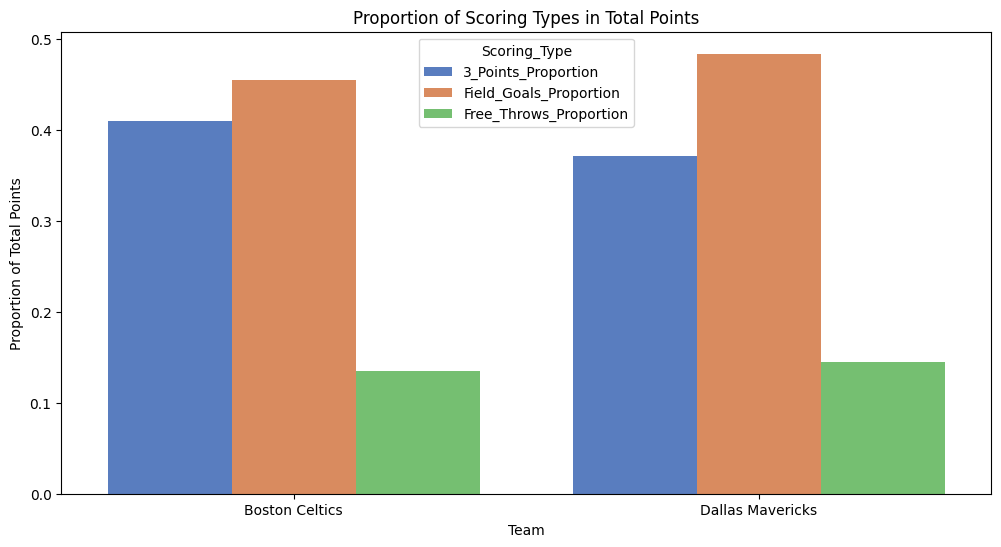

<ipython-input-7-cca265ab6c39>:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Proportion', y='Correlation', data=correlations_df, palette='muted')


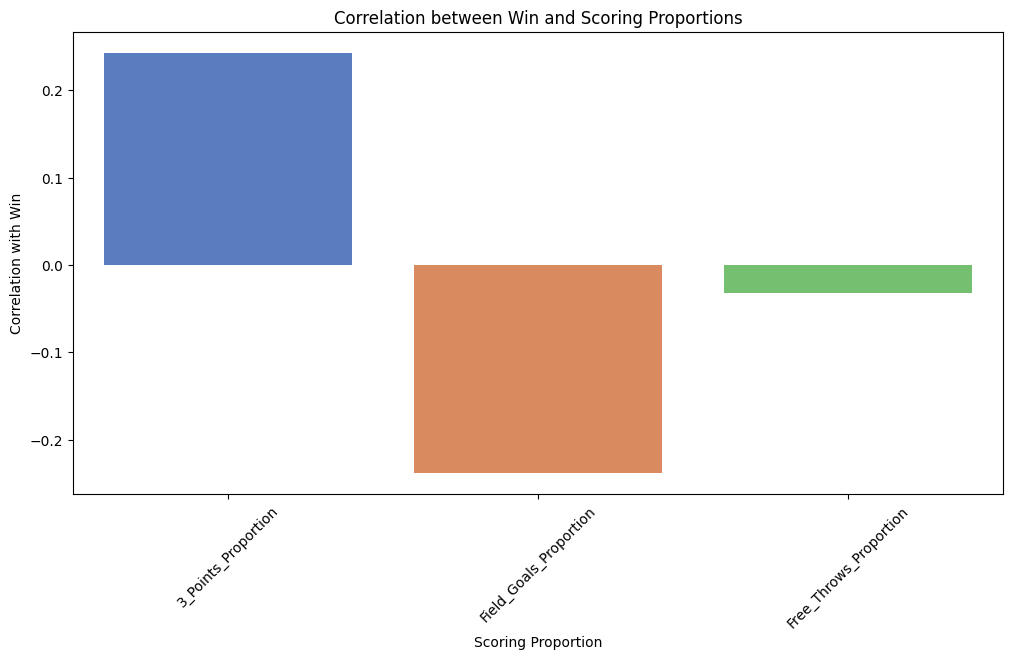

In [7]:
# Função para proporção de cada método de pontuação no total de pontos feitos
def scoring_proportions(df):
    df['Total_Points'] = df['PTS']
    df['3_Points'] = df['FG3M'] * 3
    df['Field_Goals'] = (df['FGM'] - df['FG3M']) * 2  # Retirar os 3 pontos que já foram contados
    df['Free_Throws'] = df['FTM']

    scoring_sums = df.groupby('Team')[['3_Points', 'Field_Goals', 'Free_Throws', 'Total_Points']].sum()

    scoring_sums['3_Points_Proportion'] = scoring_sums['3_Points'] / scoring_sums['Total_Points']
    scoring_sums['Field_Goals_Proportion'] = scoring_sums['Field_Goals'] / scoring_sums['Total_Points']
    scoring_sums['Free_Throws_Proportion'] = scoring_sums['Free_Throws'] / scoring_sums['Total_Points']

    scoring_proportions_df = scoring_sums[['3_Points_Proportion', 'Field_Goals_Proportion', 'Free_Throws_Proportion']].reset_index()
    scoring_proportions_df = scoring_proportions_df.melt(id_vars='Team', var_name='Scoring_Type', value_name='Proportion')

    plt.figure(figsize=(12, 6))
    sns.barplot(x='Team', y='Proportion', hue='Scoring_Type', data=scoring_proportions_df, palette='muted')
    plt.title('Proportion of Scoring Types in Total Points')
    plt.ylabel('Proportion of Total Points')
    plt.xlabel('Team')
    plt.show()

scoring_proportions(cleaned_team_gamelogs)

# Função para adicionar a coluna de vitória (Win)
def add_win_column(df):
    df['Win'] = df['WL'] == 'W'
    return df

# Adicionar a coluna de vitória
cleaned_team_gamelogs = add_win_column(cleaned_team_gamelogs)

# Função para adicionar as proporções dos métodos de pontuação
def add_scoring_proportions(df):
    df['Total_Points'] = df['PTS']
    df['3_Points'] = df['FG3M'] * 3
    df['Field_Goals'] = (df['FGM'] - df['FG3M']) * 2  # Retirar os 3 pontos que já foram contados
    df['Free_Throws'] = df['FTM']

    df['3_Points_Proportion'] = df['3_Points'] / df['Total_Points']
    df['Field_Goals_Proportion'] = df['Field_Goals'] / df['Total_Points']
    df['Free_Throws_Proportion'] = df['Free_Throws'] / df['Total_Points']

    return df

# Adicionar as proporções dos métodos de pontuação
cleaned_team_gamelogs = add_scoring_proportions(cleaned_team_gamelogs)

# Função para calcular e plotar a correlação entre proporções dos métodos de pontuação e vitórias
def plot_correlation_with_win_scoring_proportions(df):
    # Selecionar as proporções para correlação
    proportions = ['3_Points_Proportion', 'Field_Goals_Proportion', 'Free_Throws_Proportion']

    # Calcular correlações
    correlations = {}
    for proportion in proportions:
        correlation = df['Win'].astype(int).corr(df[proportion])
        correlations[proportion] = correlation

    # Converter para DataFrame
    correlations_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['Correlation']).reset_index()
    correlations_df.rename(columns={'index': 'Proportion'}, inplace=True)

    # Plotar as correlações
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Proportion', y='Correlation', data=correlations_df, palette='muted')
    plt.title('Correlation between Win and Scoring Proportions')
    plt.ylabel('Correlation with Win')
    plt.xlabel('Scoring Proportion')
    plt.xticks(rotation=45)
    plt.show()

plot_correlation_with_win_scoring_proportions(cleaned_team_gamelogs)


### **Conclusão**
Analisando a proporção de cada tipo de ponto, os times não mostram grandes diferenças no seu estilo de pontuação. Também não conseguimos conlcuir que existe uma correlaçao entre o tipo de pontuação com a vitória da partida.

## **Q4.** Nessa temporada, qual foi a média e a variância de cada indicador defensivo (Rebotes, Roubos e Bloqueios) das equipes?
* Essa análise nos ajuda a entender a eficiência defensiva e a diferença na média de cada um dos indicadores de cada equipe, assim como a variação de cada indicador ao longo da temporada.

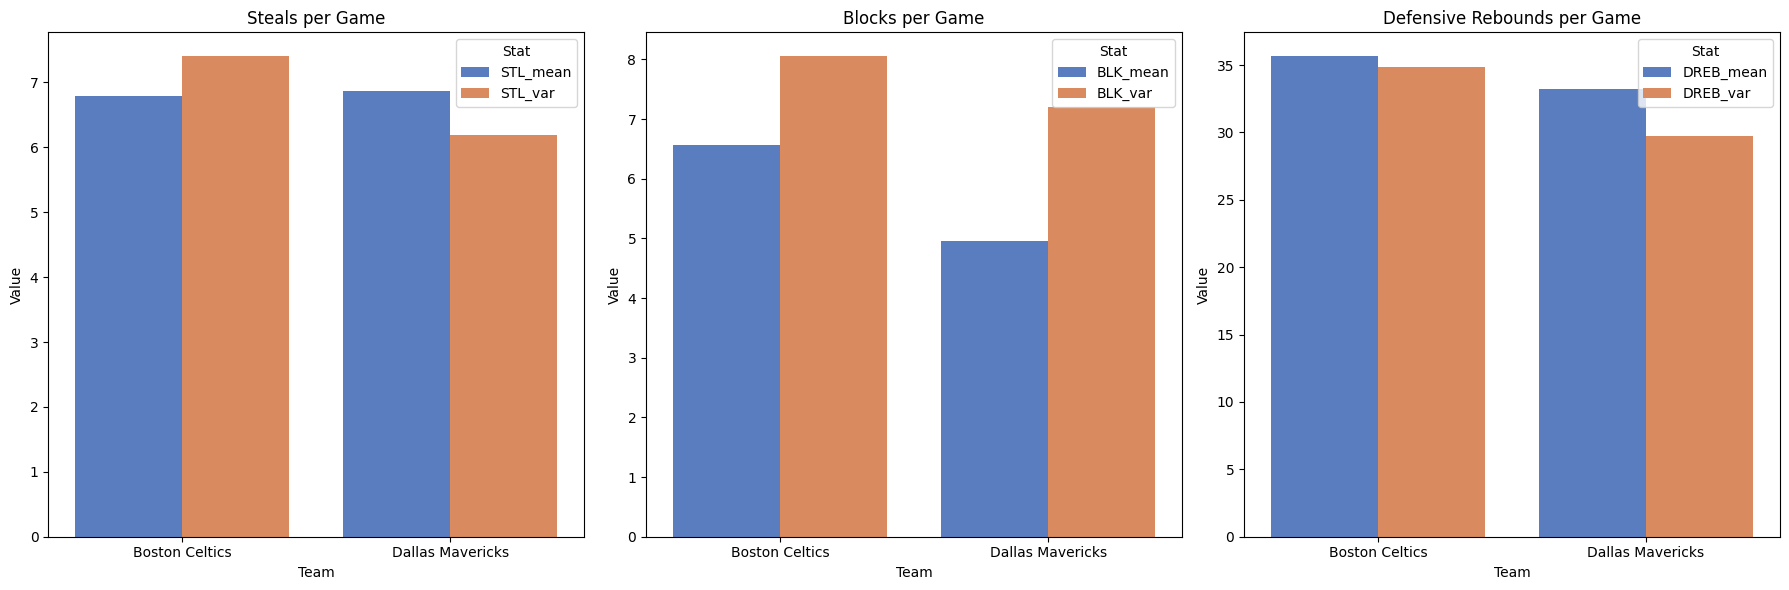

In [8]:
# Função para calcular e plotar as estatísticas defensivas (média e variância)
def plot_defensive_stats(df):
    defensive_stats = df.groupby('Team').agg({
        'STL': ['mean', 'var'],
        'BLK': ['mean', 'var'],
        'DREB': ['mean', 'var']
    }).reset_index()

    # Flatten the MultiIndex columns
    defensive_stats.columns = ['Team', 'STL_mean', 'STL_var', 'BLK_mean', 'BLK_var', 'DREB_mean', 'DREB_var']

    # Plotting the defensive stats
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Steals
    df_stl = pd.melt(defensive_stats[['Team', 'STL_mean', 'STL_var']], id_vars=['Team'], var_name='Stat', value_name='Value')
    sns.barplot(x='Team', y='Value', hue='Stat', data=df_stl, ax=axes[0], palette='muted')
    axes[0].set_title('Steals per Game')
    axes[0].set_ylabel('Value')
    axes[0].set_xlabel('Team')

    # Blocks
    df_blk = pd.melt(defensive_stats[['Team', 'BLK_mean', 'BLK_var']], id_vars=['Team'], var_name='Stat', value_name='Value')
    sns.barplot(x='Team', y='Value', hue='Stat', data=df_blk, ax=axes[1], palette='muted')
    axes[1].set_title('Blocks per Game')
    axes[1].set_ylabel('Value')
    axes[1].set_xlabel('Team')

    # Defensive Rebounds
    df_dreb = pd.melt(defensive_stats[['Team', 'DREB_mean', 'DREB_var']], id_vars=['Team'], var_name='Stat', value_name='Value')
    sns.barplot(x='Team', y='Value', hue='Stat', data=df_dreb, ax=axes[2], palette='muted')
    axes[2].set_title('Defensive Rebounds per Game')
    axes[2].set_ylabel('Value')
    axes[2].set_xlabel('Team')

    plt.tight_layout()
    plt.show()

plot_defensive_stats(cleaned_team_gamelogs)


### **Conclusão**
Olhando para os indicadores defensivos, observamos que Boston apresenta uma variância maior, e, mesmo que possuem uma média maior em cada um, isso pode ser um fator complicante, pois é necessário ter uma defesa consistente para ganhar uma final. Do outro lado, Dallas mostra ter média próximas às de Boston, com uma variância menor, o que pode indicar que sua performance seja mais consistente nas partidas.

# **Referências**

https://www.kaggle.com/datasets/wyattowalsh/basketball

https://pypi.org/project/nba_api/

https://github.com/swar/nba_api

https://www.nba.com/news/2024-nba-finals-series-preview-celtics-mavericks

https://www.nba.com/news/celtics-mavericks-24-key-stats-ahead-of-2024-nba-finals

https://chatgpt.com/

# **Conclusão**

- Em termos ofensivos, Celtics se mostra um time mais consistente e com maiores médias, sendo bastante favorito para jogos em casa.
- Em termos defensivos, Mavericks tendem a ser mais consistente, mesmo trazendo médias mais baixas no geral.
- Ambos os times possuem uma forte presença de field goals no total de pontos, apesar disso, podemos observar que não há correlação direta com as vitórias das partidas.


# **Apêndice: Vídeo, GitHub e Datafólio**

Publique (YouTube ou qualquer outro de acesso público) um vídeo explicativo apresentando o seu trabalho em no máximo 4min. Foque na relevância do problema e nos resultados obtidos. Salve em um GitHub público seu projeto (o notebook Python, dados, Datafólio).

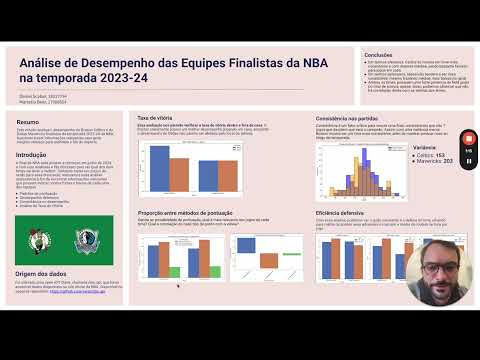

In [9]:
from IPython.display import YouTubeVideo
YouTubeVideo('GnUFujspViw') # substitua pelo seu vídeo

---

In [ ]:
#@markdown
#@title **Avaliação**
Completo = 10 #@param {type:"slider", min:0, max:10, step:1}
#@markdown São apresentadas 5-6 perguntas e empregadas estatísticas descritivas, seleções simples e múltiplas, agrupamentos e transformações dos dados.
Relevancia = 9 #@param {type:"slider", min:0, max:10, step:1}
#@markdown O tema é abordado corretamente e as perguntas e análises pertinentes ao problema.
Tecnicas = 10 #@param {type:"slider", min:0, max:10, step:1}
#@markdown As técnicas de gadas estatísticas dos dados, seleções, agrupamentos e transformações são corretamente aplicadas
Apresentacao = 5 #@param {type:"slider", min:0, max:10, step:1}
#@markdown A apresentação dos resultados é clara e objetiva
Conclusao = 8 #@param {type:"slider", min:0, max:10, step:1}
#@markdown As conclusões são justificadas e relevantes
Bonus = 0.5 #@param {type:"slider", min:0, max:1, step:0.5}
#@markdown A critério do professor por inovações na abordagem e no uso de técnicas de Análise de Dados

#@markdown ---
#@markdown ### Apresentação
Datafolio = 6 #@param {type:"slider", min:0, max:10, step:1}
Video = 7 #@param {type:"slider", min:0, max:10, step:1}





In [ ]:
#@markdown # **Nota Final**
Nota1 = Completo + Relevancia + Tecnicas + Apresentacao + Conclusao
Nota2 = Datafolio + Apresentacao

nota = (Nota1 + Nota2) / 7 + Bonus

nota = Nota1 / 5 + Bonus

print(f'Nota final do trabalho {nota :.1f}')

import numpy as np
import pandas as pd

alunos = pd.DataFrame()

lista_tia = []
lista_nome = []

for i in range(1,6):
  exec("if Aluno" + str(i) + " !='None':  lista = Aluno" + str(i) + ".split(','); lista_tia.append(lista[0]); lista_nome.append(lista[1].upper())")

alunos['tia'] = lista_tia
alunos['nome'] = lista_nome
alunos['nota'] = np.round(nota,1)
print()
display(alunos)

NameError: name 'Completo' is not defined